# Exposure at Default (EAD) and Credit Conversion Factor (CCF)

Here, we compute the **Exposure at Default (EAD)**, which represents the amount of money at risk at the moment of default.  

For this, we use the **Credit Conversion Factor (CCF)** as the target variable, defined as:

$$
\text{CCF} = \frac{\text{Loan amount} - \text{Money repaid}}{\text{Loan amount}}
$$

CCF is a **continuous variable** in the range $ (0,1) $, where:

- $ \text{CCF} = 0 $ corresponds to a perfectly good borrower  
- $ \text{CCF} = 1 $ corresponds to a perfectly bad borrower  

Unlike binary targets such as PD, we **cannot use logistic regression** here. A suitable approach is **beta regression**, which models continuous outcomes constrained between 0 and 1.

Specifically, beta regression models the conditional expected value:

$$
\mathbb{E}[\text{CCF} \mid X] = \mu(X)
$$

with a logit link function:

$$
\ln\Big(\frac{\mu(X)}{1 - \mu(X)}\Big) = \beta X
$$

where $X$ represents the set of predictor variables and $\beta$ the corresponding coefficients.


In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from sklearn.model_selection import train_test_split

import statsmodels.api as sm
from statsmodels.othermod.betareg import BetaModel

from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import pickle

import warnings
warnings.filterwarnings("ignore")

### Import data

In [2]:
df_prep = pd.read_csv('data/loan_inputs_train.csv')
df_prep.head()

,Unnamed: 0.1,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,...,mths_since_last_delinq:70_80,mths_since_last_record:<36,mths_since_last_record:37_66,mths_since_last_record:67_121,mths_since_last_record:122_127,dti_factor,dti:<1,dti:1_6,dti:7_30,dti:30_40
0,269056,269056,NaN,NaN,20000,20000,20000.0,36 months,7.46,621.76,...,0,0,0,1,0,"(-0.999, 19.98]",1,0,0,0
1,499174,499174,NaN,NaN,30000,30000,30000.0,36 months,11.49,989.14,...,0,0,0,0,0,"(19.98, 39.96]",0,0,1,0
2,85143,85143,NaN,NaN,17000,17000,17000.0,60 months,6.67,333.98,...,0,0,0,0,0,"(19.98, 39.96]",0,0,1,0
3,260335,260335,NaN,NaN,24000,24000,24000.0,36 months,6.83,739.19,...,0,0,0,1,0,"(-0.999, 19.98]",0,0,1,0
4,338124,338124,NaN,NaN,30000,30000,30000.0,60 months,9.92,636.24,...,0,0,0,0,0,"(-0.999, 19.98]",0,0,1,0


Note, we will model cases only when loan was charged off, and ignore cases where borrower fully paid.

In [3]:
df_defaults = df_prep[df_prep['loan_status'].isin(['Charged Off'])]
df_defaults.shape

(6047, 325)

In [4]:
# pd.options.display.max_rows = None

In [5]:
df_defaults.isnull().sum()

Unnamed: 0.1       0
Unnamed: 0         0
id              6047
member_id       6047
loan_amnt          0
                ... 
dti_factor         0
dti:<1             0
dti:1_6            0
dti:7_30           0
dti:30_40          0
Length: 325, dtype: int64

### Independent variables

we fix missing values

In [6]:
df_defaults['mths_since_last_delinq'].fillna(0)

104        9.0
132        0.0
246        0.0
415        0.0
489       61.0
          ... 
399018     0.0
399061     0.0
399548    39.0
399750     0.0
399912     0.0
Name: mths_since_last_delinq, Length: 6047, dtype: float64

In [7]:
df_defaults['mths_since_last_record'].fillna(0)

104         0.0
132         0.0
246         0.0
415       111.0
489         0.0
          ...  
399018      0.0
399061     96.0
399548      0.0
399750      0.0
399912     27.0
Name: mths_since_last_record, Length: 6047, dtype: float64

### Dependent variable: CCF

In [8]:
df_defaults['CCF'] = (df_defaults['funded_amnt'] - df_defaults['total_rec_prncp']) / df_defaults['funded_amnt']
df_defaults['CCF'].describe()

count    6047.000000
mean        0.914510
std         0.098992
min         0.000000
25%         0.892578
50%         0.937587
75%         0.968732
max         1.000000
Name: CCF, dtype: float64

Note that, CCF is bounded within 0 and 1. Still to be safe, we clip it slightly

In [9]:
eps = 1e-4
df_defaults['CCF'] = np.clip(df_defaults['CCF'], eps, 1-eps)

In [10]:
# df_defaults.to_csv('data/df_defaults.csv')

### Explore dependent variables

Text(0.5, 0, 'CCF')

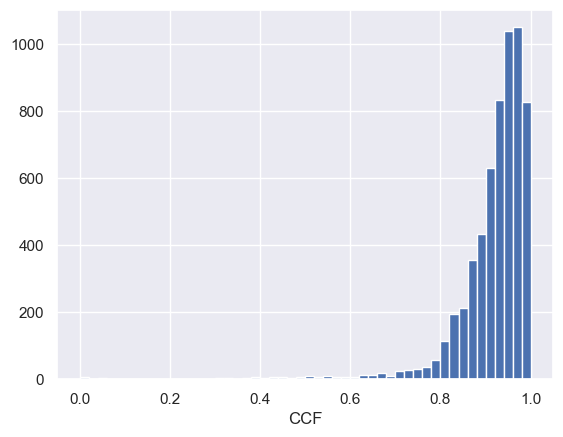

In [11]:
plt.hist(df_defaults['CCF'], bins=50)
plt.xlabel('CCF')

### Training

This part is almost same as PD model, except we use beta regression here.

In [12]:
#remove dependent variables from inputs and pass with target variable
x_train, x_test, y_train, y_test = train_test_split(df_defaults.drop(['loan_status', 'CCF'], axis=1),
                                                    df_defaults['CCF'],
                                                    test_size=0.2,
                                                    random_state=42)

In [13]:
with open('data/dummy_variables_revised.txt') as f:
    all_cols_revised = [line.strip() for line in f] #all columns

with open('data/ref_variables_revised.txt') as f:
    ref_cols_revised = [line.strip() for line in f] #reference columns (safest baseline variables)

inputs_train_w_ref_cols = x_train.loc[:, all_cols_revised]
inputs_train = inputs_train_w_ref_cols.drop(ref_cols_revised, axis=1)
inputs_train.head()

,grade:B,grade:C,grade:D,grade:E,grade:F_G,addr_state:HI_MS_OK_AL,addr_state:NY_FL,addr_state:NM_SD_NV,addr_state:MD_MI_NC,addr_state:AR,...,mths_since_last_delinq:3_16,mths_since_last_delinq:48_64,mths_since_last_delinq:65_70,mths_since_last_delinq:70_80,mths_since_last_record:<36,mths_since_last_record:37_66,mths_since_last_record:122_127,dti:<1,dti:1_6,dti:30_40
375967,False,True,False,False,False,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
264863,False,True,False,False,False,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
73007,False,True,False,False,False,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
75064,True,False,False,False,False,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
342702,False,True,False,False,False,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [14]:
inputs_train_num = inputs_train.apply(pd.to_numeric)
y_train = pd.to_numeric(y_train)

In [15]:
x = sm.add_constant(inputs_train_num.astype(float))
y = y_train.astype(float)

betamodel = BetaModel(y, x)
ead_model = betamodel.fit()
print(ead_model.summary())

                              BetaModel Results                               
Dep. Variable:                    CCF   Log-Likelihood:                 7093.2
Model:                      BetaModel   AIC:                        -1.408e+04
Method:            Maximum Likelihood   BIC:                        -1.375e+04
Date:                Sun, 15 Feb 2026                                         
Time:                        15:57:13                                         
No. Observations:                4837                                         
Df Residuals:                    4786                                         
Df Model:                          49                                         
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                   3.3894      0.368      9.203      0.000  

As we go high up in grades for example, coefficinets decrease, which indicate better borrowing quality

### Test

In [16]:
with open('data/dummy_variables_revised.txt') as f:
    all_cols_revised = [line.strip() for line in f] #all columns

with open('data/ref_variables_revised.txt') as f:
    ref_cols_revised = [line.strip() for line in f] #reference columns (safest baseline variables)

inputs_test_w_ref_cols = x_test.loc[:, all_cols_revised]
inputs_test = inputs_test_w_ref_cols.drop(ref_cols_revised, axis=1)
inputs_test.head()

,grade:B,grade:C,grade:D,grade:E,grade:F_G,addr_state:HI_MS_OK_AL,addr_state:NY_FL,addr_state:NM_SD_NV,addr_state:MD_MI_NC,addr_state:AR,...,mths_since_last_delinq:3_16,mths_since_last_delinq:48_64,mths_since_last_delinq:65_70,mths_since_last_delinq:70_80,mths_since_last_record:<36,mths_since_last_record:37_66,mths_since_last_record:122_127,dti:<1,dti:1_6,dti:30_40
353542,False,False,True,False,False,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
153469,False,True,False,False,False,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
386168,False,False,True,False,False,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
286449,False,False,True,False,False,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
88253,False,False,False,True,False,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
inputs_test_num = inputs_test.apply(pd.to_numeric)
loan_target_test_num = pd.to_numeric(y_test)

tr = 0.5
X_test_const = sm.add_constant(inputs_test.astype(float))
y_pred_prob = ead_model.predict(X_test_const)  # probabilities of y=1
y_pred_class = (y_pred_prob >= tr).astype(int) 

y_pred = y_pred_prob
y_true = loan_target_test_num.astype(float)

# RMSE manually
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# R^2
r2 = r2_score(y_true, y_pred)

# MAE
mae = mean_absolute_error(y_true, y_pred)

print("RMSE:", rmse)
print("R^2:", r2)
print("MAE:", mae)

RMSE: 0.09657134652358637
R^2: 0.06359118464091584
MAE: 0.056235304400472


In [18]:
y_pred.describe() #is within (0,1)

count    1210.000000
mean        0.906105
std         0.024515
min         0.712455
25%         0.888819
50%         0.905373
75%         0.925414
max         0.965120
dtype: float64

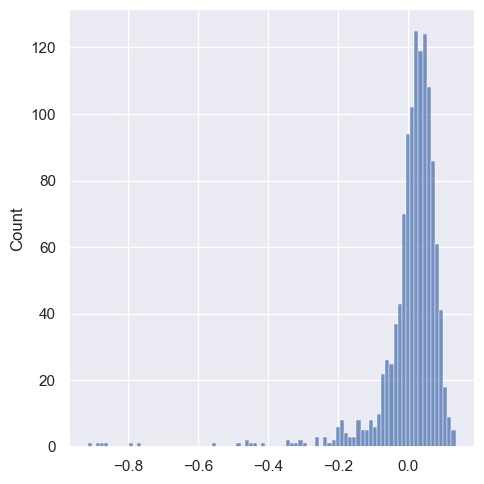

In [19]:
sns.displot(y_true-y_pred)

Residuals are normally distributed around 0, which is what we expect

In [20]:
#save model
with open('data/ead_model.pkl', 'wb') as f:
    pickle.dump(ead_model, f)